In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [6]:
scan_data = pd.read_csv('sales_scan_data.csv')

scan_data.head()

,Date,Account,Market,Brand,Package,Units_Sold,Dollars_Sold,Promoted
0,2024-09-01,Safeway,CO,Chris' Brewing Company Torpedo,6pk Cans,318,1009.53,N
1,2024-05-05,Costco,CA,Competitor IPA,12pk Bottles,327,3525.24,Y
2,2024-12-08,Publix,CO,Chris' Brewing Company Hazy IPA,6pk Cans,425,3144.20,Y
3,2024-05-19,Costco,TX,Competitor IPA,Single Draft,193,2870.24,N
4,2024-03-31,Kroger,TX,Chris' Brewing Company Hazy IPA,Single Draft,428,4216.18,N


In [17]:
scan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          200 non-null    object 
 1   Account       200 non-null    object 
 2   Market        200 non-null    object 
 3   Brand         200 non-null    object 
 4   Package       200 non-null    object 
 5   Units_Sold    200 non-null    int64  
 6   Dollars_Sold  200 non-null    float64
 7   Promoted      200 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 12.6+ KB


In [10]:
# updating to datetime

scan_data['Date'] = pd.to_datetime(scan_data['Date'])

In [11]:
scan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          200 non-null    datetime64[ns]
 1   Account       200 non-null    object        
 2   Market        200 non-null    object        
 3   Brand         200 non-null    object        
 4   Package       200 non-null    object        
 5   Units_Sold    200 non-null    int64         
 6   Dollars_Sold  200 non-null    float64       
 7   Promoted      200 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 12.6+ KB


# **Sales & Category Growth**

* 1. Which products are growing fastest vs. declining in volume and dollars?

* 2. How does sales growth compare to the category average in each market?

* 3. What’s the sales mix between promoted and non-promoted volume?

## 1. Which products are growing fastest vs. declining in volume and dollars?

In [7]:
# sorting scan data

scan_data = scan_data.sort_values(['Brand','Package', 'Date']).reset_index(drop=True)

In [8]:
scan_data.head()

,Date,Account,Market,Brand,Package,Units_Sold,Dollars_Sold,Promoted
0,2024-01-14,Whole Foods,PA,Chris' Brewing Company Hazy IPA,12pk Bottles,219,2560.22,N
1,2024-01-14,Costco,PA,Chris' Brewing Company Hazy IPA,12pk Bottles,118,988.19,Y
2,2024-01-28,Publix,NC,Chris' Brewing Company Hazy IPA,12pk Bottles,260,2462.05,Y
3,2024-02-11,Safeway,NC,Chris' Brewing Company Hazy IPA,12pk Bottles,95,4910.05,N
4,2024-02-25,Costco,NC,Chris' Brewing Company Hazy IPA,12pk Bottles,105,4472.80,N


In [12]:
# creating a year/month column

scan_data['year_month'] = scan_data['Date'].dt.to_period('M').astype(str)

scan_data.head()

,Date,Account,Market,Brand,Package,Units_Sold,Dollars_Sold,Promoted,year_month
0,2024-01-14,Whole Foods,PA,Chris' Brewing Company Hazy IPA,12pk Bottles,219,2560.22,N,2024-01
1,2024-01-14,Costco,PA,Chris' Brewing Company Hazy IPA,12pk Bottles,118,988.19,Y,2024-01
2,2024-01-28,Publix,NC,Chris' Brewing Company Hazy IPA,12pk Bottles,260,2462.05,Y,2024-01
3,2024-02-11,Safeway,NC,Chris' Brewing Company Hazy IPA,12pk Bottles,95,4910.05,N,2024-02
4,2024-02-25,Costco,NC,Chris' Brewing Company Hazy IPA,12pk Bottles,105,4472.80,N,2024-02


In [15]:
# looking at monthly sales

monthly_sales = (scan_data
     .groupby(['year_month', 'Brand', 'Package'])
     .agg({
         'Units_Sold' : 'sum',
         'Dollars_Sold': 'sum'
     })
     .reset_index()
)

#looking at month over month growth/decline
monthly_sales['Unit_Growth'] = monthly_sales.groupby(['Brand', 'Package'])['Units_Sold'].pct_change().round(3)
monthly_sales['Dollar_Growth'] = monthly_sales.groupby(['Brand', 'Package'])['Dollars_Sold'].pct_change().round(3)

In [16]:
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year_month     127 non-null    object 
 1   Brand          127 non-null    object 
 2   Package        127 non-null    object 
 3   Units_Sold     127 non-null    int64  
 4   Dollars_Sold   127 non-null    float64
 5   Unit_Growth    112 non-null    float64
 6   Dollar_Growth  112 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 7.1+ KB


In [20]:
brand_growth = (monthly_sales
    .groupby(['year_month','Brand', 'Package'])
     .agg(
         avg_units_growth=('Unit_Growth', 'mean'),
         avg_dollars_growth=('Dollar_Growth', 'mean')
     )
     .reset_index()
)


In [21]:
avg_by_brand = (brand_growth
   .groupby(['Brand', 'Package'])
   .agg(
       mean_units_growth=('avg_units_growth', 'mean'),
       mean_dollars_growth=('avg_dollars_growth', 'mean')
   )
   .reset_index()
)

top_5 = avg_by_brand.sort_values('mean_units_growth', ascending=False).head(5)
bottom_5 = avg_by_brand.sort_values('mean_units_growth').head(5)


In [22]:
top_5

,Brand,Package,mean_units_growth,mean_dollars_growth
12,Competitor Lager,12pk Bottles,4.785500,0.181333
2,Chris' Brewing Company Hazy IPA,Single Draft,1.843444,1.321778
9,Competitor IPA,12pk Bottles,1.562125,0.705250
5,Chris' Brewing Company Pale Ale,Single Draft,1.549833,0.448500
1,Chris' Brewing Company Hazy IPA,6pk Cans,1.454500,0.354667


In [23]:
bottom_5

,Brand,Package,mean_units_growth,mean_dollars_growth
6,Chris' Brewing Company Torpedo,12pk Bottles,-0.055125,0.357375
14,Competitor Lager,Single Draft,0.086286,0.870429
8,Chris' Brewing Company Torpedo,Single Draft,0.267167,1.507000
0,Chris' Brewing Company Hazy IPA,12pk Bottles,0.373778,1.212000
4,Chris' Brewing Company Pale Ale,6pk Cans,0.375545,0.472091


In [24]:
corr = avg_by_brand['mean_units_growth'].corr(avg_by_brand['mean_dollars_growth'])

In [25]:
corr_units = torpedo['Promoted_Flag'].corr(torpedo['Units_Sold'])
corr_dollars = torpedo['Promoted_Flag'].corr(torpedo['Dollars_Sold'])

print(f"Corr with units sold: {corr_units:.2f}")
print(f"Corr with dollars sold: {corr_dollars:.2f}")

NameError: name 'torpedo' is not defined

In [26]:
# looking at promotional lifts
promo_summary = (scan_data
    .groupby(['Brand', 'Package', 'Promoted'])
     .agg(
         avg_units=('Units_Sold', 'mean'),
         avg_dollars=('Dollars_Sold', 'mean'),
         obs=('Units_Sold', 'size') # number of observations
     )
)

promo_summary

avg_units  \
Brand                           Package      Promoted               
Chris' Brewing Company Hazy IPA 12pk Bottles N         189.250000   
                                             Y         231.500000   
                                6pk Cans     N         306.222222   
                                             Y         275.500000   
                                Single Draft N         298.363636   
                                             Y          69.000000   
Chris' Brewing Company Pale Ale 12pk Bottles N         301.545455   
                                             Y         295.500000   
                                6pk Cans     N         369.400000   
                                             Y         315.600000   
                                Single Draft N         194.100000   
                                             Y         243.000000   
Chris' Brewing Company Torpedo  12pk Bottles N         268.400000   
                                             Y         321.333333   
                                6pk Cans     N         287.000000   
                                             Y         369.666667   
                                Single Draft N         220.750000   
                                             Y         298.000000   
Competitor IPA                  12pk Bottles N         210.571429   
                                             Y         287.444444   
                                6pk Cans     N         259.500000   
                                             Y         222.250000   
                                Single Draft N         261.818182   
                                             Y         204.000000   
Competitor Lager                12pk Bottles N         149.625000   
                                             Y         156.166667   
                                6pk Cans     N         283.285714   
                                             Y         255.166667   
                                Single Draft N         305.583333   
                                             Y         280.333333   

                                                       avg_dollars  obs  
Brand                           Package      Promoted                    
Chris' Brewing Company Hazy IPA 12pk Bottles N         2875.012500    8  
                                             Y         1586.986667    6  
                                6pk Cans     N         1937.400000    9  
                                             Y         3976.420000    2  
                                Single Draft N         2467.690000   11  
                                             Y         2785.350000    2  
Chris' Brewing Company Pale Ale 12pk Bottles N         2324.361818   11  
                                             Y         2186.430000    2  
                                6pk Cans     N         2119.552000   10  
                                             Y         2793.840000    5  
                                Single Draft N         3226.949000   10  
                                             Y         1962.120000    6  
Chris' Brewing Company Torpedo  12pk Bottles N         1591.611000   10  
                                             Y         2431.386667    3  
                                6pk Cans     N         2282.377500    8  
                                             Y         2529.303333    3  
                                Single Draft N         2658.045000    8  
                                             Y         1561.856667    3  
Competitor IPA                  12pk Bottles N         2685.980000    7  
                                             Y         3311.474444    9  
                                6pk Cans     N         2910.061250    8  
                                             Y         2201.997500    4  
                                Single Draft N         1961.615455   11

In [27]:
promo_pivot = (promo_summary
                    .pivot_table(index=['Brand', 'Package'],
                    columns='Promoted',
                    values=['avg_units', 'avg_dollars'])
)

promo_pivot.columns = ['avg_dollars_n', 'avg_dollars_y', 'avg_units_n', 'avg_units_y']

promo_pivot = promo_pivot.reset_index()

promo_pivot['dollars_lift_%'] = (promo_pivot['avg_dollars_y'] / promo_pivot['avg_dollars_n'] - 1) * 100

promo_pivot['unit_lift_%'] = (promo_pivot['avg_units_y'] / promo_pivot['avg_units_n'] - 1) * 100

promo_pivot.head()

,Brand,Package,avg_dollars_n,avg_dollars_y,avg_units_n,avg_units_y,dollars_lift_%,unit_lift_%
0,Chris' Brewing Company Hazy IPA,12pk Bottles,2875.012500,1586.986667,189.250000,231.5,-44.800704,22.324967
1,Chris' Brewing Company Hazy IPA,6pk Cans,1937.400000,3976.420000,306.222222,275.5,105.245174,-10.032656
2,Chris' Brewing Company Hazy IPA,Single Draft,2467.690000,2785.350000,298.363636,69.0,12.872768,-76.873857
3,Chris' Brewing Company Pale Ale,12pk Bottles,2324.361818,2186.430000,301.545455,295.5,-5.934180,-2.004824
4,Chris' Brewing Company Pale Ale,6pk Cans,2119.552000,2793.840000,369.400000,315.6,31.812760,-14.564158


In [28]:
top_5_unit_lift = promo_pivot.sort_values('unit_lift_%', ascending=False).head(5)
top_5_unit_lift

,Brand,Package,avg_dollars_n,avg_dollars_y,avg_units_n,avg_units_y,dollars_lift_%,unit_lift_%
9,Competitor IPA,12pk Bottles,2685.9800,3311.474444,210.571429,287.444444,23.287383,36.506860
8,Chris' Brewing Company Torpedo,Single Draft,2658.0450,1561.856667,220.750000,298.000000,-41.240398,34.994337
7,Chris' Brewing Company Torpedo,6pk Cans,2282.3775,2529.303333,287.000000,369.666667,10.818799,28.803717
5,Chris' Brewing Company Pale Ale,Single Draft,3226.9490,1962.120000,194.100000,243.000000,-39.195816,25.193199
0,Chris' Brewing Company Hazy IPA,12pk Bottles,2875.0125,1586.986667,189.250000,231.500000,-44.800704,22.324967


In [29]:
bottom_5_unit_lift = promo_pivot.sort_values('unit_lift_%').head(5)
bottom_5_unit_lift

,Brand,Package,avg_dollars_n,avg_dollars_y,avg_units_n,avg_units_y,dollars_lift_%,unit_lift_%
2,Chris' Brewing Company Hazy IPA,Single Draft,2467.690000,2785.3500,298.363636,69.00,12.872768,-76.873857
11,Competitor IPA,Single Draft,1961.615455,2839.0450,261.818182,204.00,44.729947,-22.083333
4,Chris' Brewing Company Pale Ale,6pk Cans,2119.552000,2793.8400,369.400000,315.60,31.812760,-14.564158
10,Competitor IPA,6pk Cans,2910.061250,2201.9975,259.500000,222.25,-24.331575,-14.354528
1,Chris' Brewing Company Hazy IPA,6pk Cans,1937.400000,3976.4200,306.222222,275.50,105.245174,-10.032656


## 💡 Key Insights — Product Growth & Promotion Impact

**Overall Findings**
- *Torpedo 12 pk Bottles* shows the strongest promotional response (**+53 % dollar lift**, **≈ +20 % unit lift**), indicating effective promotions and strong consumer pull.
- *Hazy IPA 12 pk Bottles* shows **+22 % unit lift** but **−45 % dollar lift**, suggesting deeper discounting or lower-priced accounts during promotions.
- *Pale Ale 6 pk Cans* shows **+32 % dollar lift** but **−15 % unit lift**, implying pricing-driven gains without volume growth.
- *Hazy IPA 6 pk Cans* shows **+105 % dollar lift** with **−10 % unit lift**, likely reflecting mix or premium placement effects.


* **Month-over-Month Performance**
* **Torpedo 12 pk Bottles** shows the strongest promotional response, with **+53 % dollar lift** and **+20 % unit lift**, indicating effective promotions and healthy consumer demand.  
* **Hazy IPA 12 pk Bottles** increased **units (+22 %)** but saw a **–45 % dollar lift**, suggesting deeper discounting or promotions concentrated in lower-priced markets.


**Correlation Insight**
- The overall correlation between unit and dollar growth (**r = 0.42**) indicates a **modest positive relationship**.  
  Pricing, product mix, and promotion strategy are key factors influencing value growth beyond pure sales volume.

---


## **2. How does CBC’s sales growth compare to the category average in each market?**

In [31]:
# aggregating CBC vs competitor sales by market and month

agg_monthly_sales = scan_data.groupby(['year_month', 'Market', 'Brand'])[['Units_Sold', 'Dollars_Sold']].sum()

agg_monthly_sales

Units_Sold  Dollars_Sold
year_month Market Brand                                                    
2024-01    CA     Chris' Brewing Company Pale Ale         300       2496.89
                  Chris' Brewing Company Torpedo           74       3152.94
                  Competitor IPA                          164        605.01
                  Competitor Lager                        498       1073.51
           CO     Chris' Brewing Company Hazy IPA         182       1598.69
...                                                       ...           ...
2024-12    PA     Competitor IPA                          560       6736.39
                  Competitor Lager                         22       1151.18
           TX     Chris' Brewing Company Hazy IPA         334        704.18
                  Chris' Brewing Company Torpedo          393        517.69
                  Competitor IPA                          350       3579.57

[147 rows x 2 columns]

In [32]:
agg_monthly_units_pivot = (agg_monthly_sales
                             .pivot_table(index=['year_month', 'Market'],
                                         columns='Brand',
                                         values='Units_Sold',
                                         aggfunc='sum',
                                         fill_value=0)
                             .reset_index()
                            )

agg_monthly_units_pivot.head(10)

Brand,year_month,Market,Chris' Brewing Company Hazy IPA,Chris' Brewing Company Pale Ale,Chris' Brewing Company Torpedo,Competitor IPA,Competitor Lager
0,2024-01,CA,0,300,74,164,498
1,2024-01,CO,182,0,266,0,164
2,2024-01,NC,260,405,0,0,0
3,2024-01,PA,337,0,0,0,488
4,2024-01,TX,0,0,0,0,215
5,2024-02,CA,333,0,0,297,0
6,2024-02,CO,75,391,499,0,0
7,2024-02,NC,200,0,174,0,0
8,2024-02,PA,126,0,0,178,0
9,2024-02,TX,0,0,0,0,211


In [35]:
agg_monthly_units_pivot['CBC_Total'] = (agg_monthly_units_pivot["Chris' Brewing Company Hazy IPA"] +
                                            agg_monthly_units_pivot["Chris' Brewing Company Pale Ale"] +
                                            agg_monthly_units_pivot["Chris' Brewing Company Torpedo"]   
)

agg_monthly_units_pivot['Category_Total'] = (agg_monthly_units_pivot['Competitor IPA'] +
                                            agg_monthly_units_pivot['Competitor Lager'] +
                                            agg_monthly_units_pivot['CBC_Total']   
)

agg_monthly_units_pivot.head(20)

Brand,year_month,Market,Chris' Brewing Company Hazy IPA,Chris' Brewing Company Pale Ale,Chris' Brewing Company Torpedo,Competitor IPA,Competitor Lager,CBC_Total,Category_Total
0,2024-01-01,CA,0,300,74,164,498,374,1036
5,2024-02-01,CA,333,0,0,297,0,333,630
10,2024-03-01,CA,0,0,0,0,57,0,57
15,2024-04-01,CA,1120,0,396,292,426,1516,2234
20,2024-05-01,CA,0,0,333,327,480,333,1140
25,2024-06-01,CA,0,354,494,107,202,848,1157
30,2024-07-01,CA,0,0,0,601,0,0,601
35,2024-08-01,CA,150,0,0,0,0,150,150
40,2024-09-01,CA,926,418,409,385,23,1753,2161
45,2024-10-01,CA,0,0,257,0,236,257,493


In [37]:
# making year_month a datetime for plotting, making sure all values are sorted properly for plotting

agg_monthly_units_pivot['year_month'] = pd.to_datetime(agg_monthly_units_pivot['year_month'])
agg_monthly_units_pivot = agg_monthly_units_pivot.sort_values(['Market', 'year_month'])

In [38]:
agg_monthly_units_pivot['CBC_Share'] = (agg_monthly_units_pivot['CBC_Total'] /
                                            agg_monthly_units_pivot['Category_Total'])

agg_monthly_units_pivot.head()

Brand,year_month,Market,Chris' Brewing Company Hazy IPA,Chris' Brewing Company Pale Ale,Chris' Brewing Company Torpedo,Competitor IPA,Competitor Lager,CBC_Total,Category_Total,CBC_Share
0,2024-01-01,CA,0,300,74,164,498,374,1036,0.361004
5,2024-02-01,CA,333,0,0,297,0,333,630,0.528571
10,2024-03-01,CA,0,0,0,0,57,0,57,0.000000
15,2024-04-01,CA,1120,0,396,292,426,1516,2234,0.678603
20,2024-05-01,CA,0,0,333,327,480,333,1140,0.292105


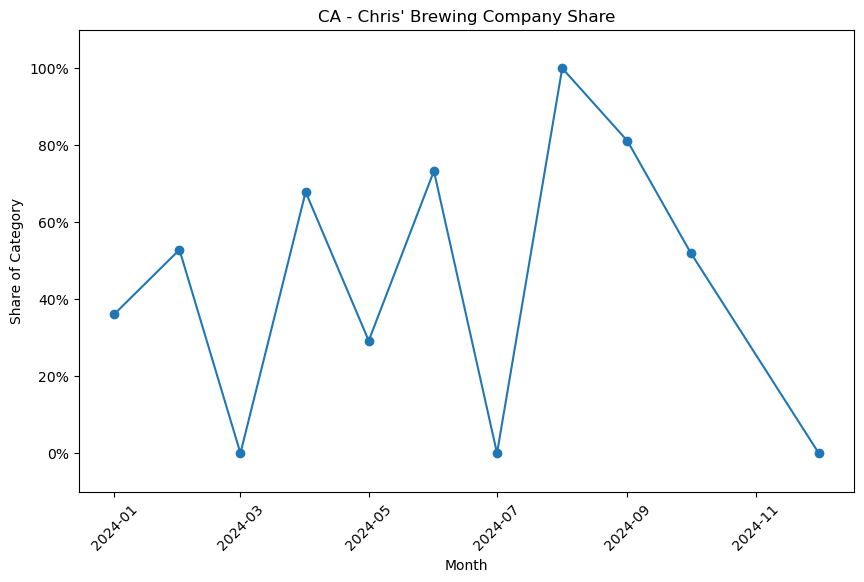

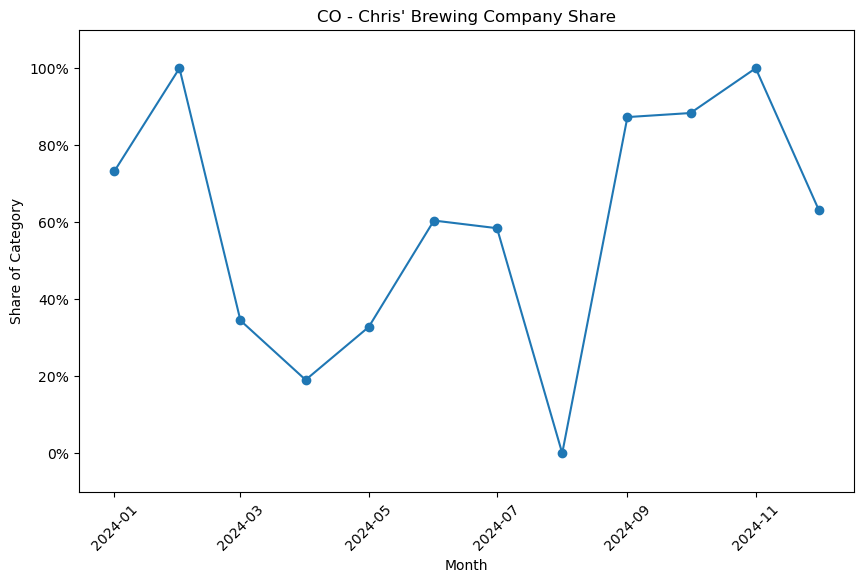

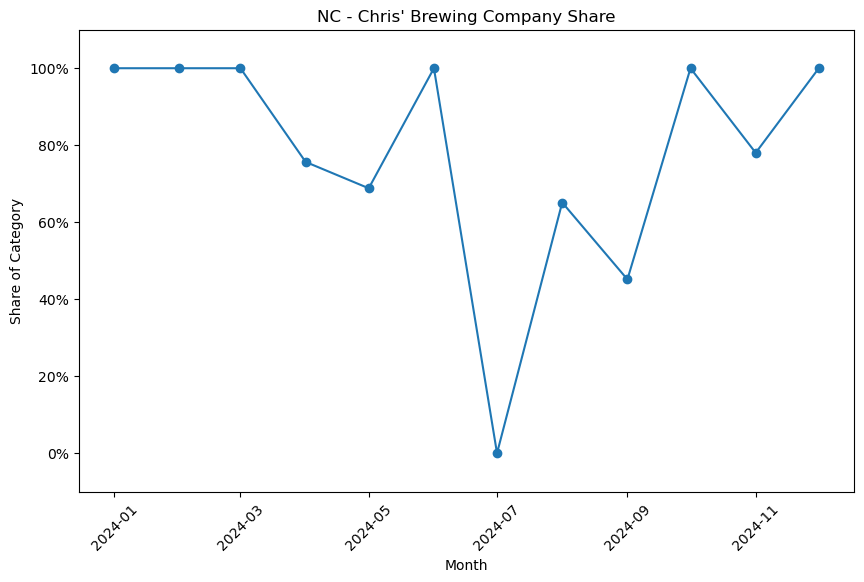

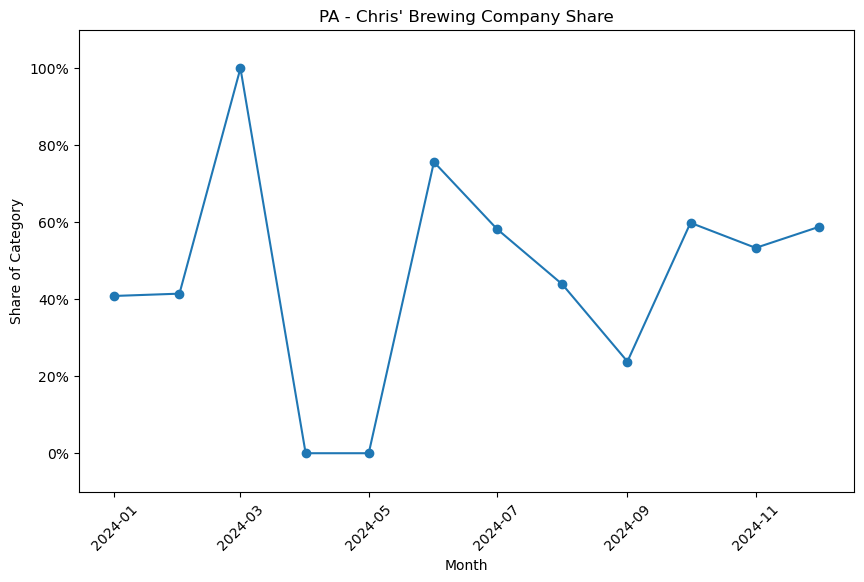

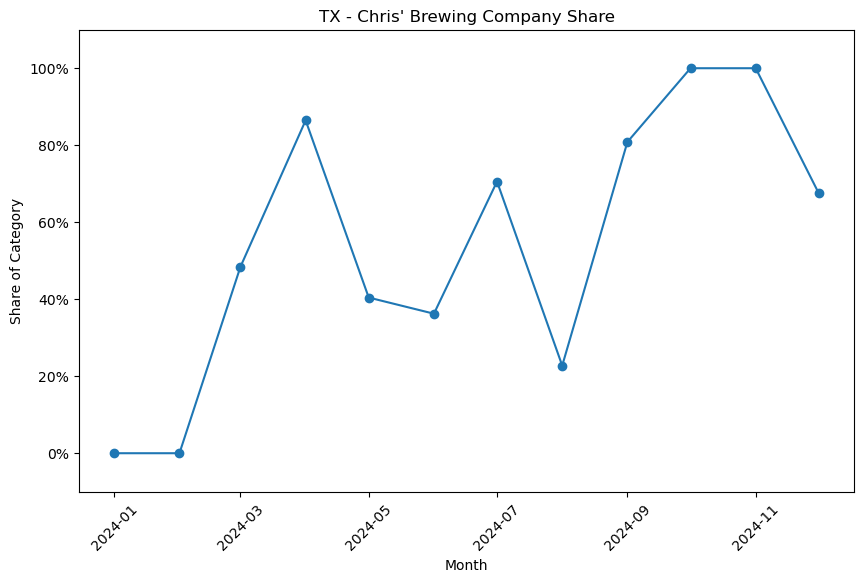

In [40]:
# plotting category share by Market

for market, subset in agg_monthly_units_pivot.groupby('Market'):
    plt.figure(figsize=(10,6))
    plt.plot(subset['year_month'], subset['CBC_Share'], marker='o', label="Chris' Brewing Company Category Share")
    
    plt.title(f"{market} - Chris' Brewing Company Share")
    plt.xlabel('Month')
    plt.ylabel('Share of Category')
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.xticks(rotation=45)
    plt.ylim(-0.1,1.1)
    plt.show()

## 📊 Market-Level Summary — Category Share

### **California (CA)**
- Share ranged widely from **0% → 100%**, with volatile periods due to months of no sales followed by strong re-entries.  
- Peak share in **Aug (100%)** and **Sep (81%)**, showing CBC dominance when active.  
- Lowest share in **Mar and Dec (0%)** where no CBC sales were recorded.  
- Trend: **Inconsistent presence**, but when distributed, CBC commands majority of category volume.

---

### **Colorado (CO)**
- CBC maintained **strong share** overall, often above **60%**, peaking at **100%** in Feb and Nov.  
- Lowest share in **Apr (19%)** when competitor activity spiked.  
- Ended the year at **63%**, showing **steady performance** despite fluctuations mid-year.  
- Trend: **CBC leads most months**, with minor dips tied to competitor reactivations.

---

### **North Carolina (NC)**
- Early-year dominance (**100% share Jan–Mar**) before dipping mid-year as competitors entered.  
- Lowest share in **Sep (45%)**, then rebounded to **100% by Oct and Dec**.  
- Trend: **Strong regional control** with brief mid-year competition pressure, ending on top.

---

### **Pennsylvania (PA)**
- Share started moderate (**41%–42% in Q1**), dipped to **0% Apr–May**, then recovered in June (**76%**) and stabilized near **60%** late in the year.  
- Lowest share: **0% in Apr–May**, no CBC sales.  
- Trend: **Recovery story** — after early outages, CBC regained share through consistent late-year performance.

---

### **Texas (TX)**
- Began with **0% share** in Jan–Feb, then surged to **86% in Apr** driven by strong Hazy IPA and Pale Ale performance.  
- Dipped mid-year but recovered to **~68% by Dec**.  
- Trend: **Fast-growing presence** — CBC entered late but gained traction quickly and sustained strong market share.

---

### **Overall Takeaways**
- **CBC leads or dominates in most active markets**, particularly **CO, NC, and TX**.  
- **Volatility** in CA and PA stems from intermittent months with no recorded sales.  
- When present, **CBC typically holds >60% share**, reflecting brand strength where distributed.  
- Markets with early-year gaps may benefit from **consistent distribution and promotional continuity** to stabilize share performance.


In [43]:
# Average share by market

(agg_monthly_units_pivot
 .groupby(['Market'], as_index=False)['CBC_Share'].mean()
 .sort_values('CBC_Share', ascending=False)
)

Brand,Market,CBC_Share
2,NC,0.777310
1,CO,0.597724
4,TX,0.544338
3,PA,0.463202
0,CA,0.447792


## 🧭 Average Category Share by Market

| Market | Avg. Category Share | Interpretation |
|:-------|:-------------------:|:---------------|
| **NC** | **77.7%** | Sierra Nevada holds the dominant position, maintaining strong category leadership throughout the year. |
| **CO** | **59.8%** | Consistent share and stable performance — Sierra Nevada is a clear leader but faces steady competition. |
| **TX** | **54.4%** | Rapid share growth following mid-year expansion, suggesting momentum in a developing market. |
| **PA** | **46.3%** | Competitive landscape with share recovery in later months; opportunity for sustained presence. |
| **CA** | **44.8%** | Volatile performance due to inconsistent availability; strong peaks offset by months with minimal sales. |

**Overall Insight:**  
Sierra Nevada leads the category in **most markets**, averaging **56% share** overall. The brand is particularly strong in **NC and CO**, while **CA and PA** show growth potential if distribution gaps and volatility are addressed.
